# CVRP
VRP : https://developers.google.com/optimization/routing/vrp \
CVRP : https://developers.google.com/optimization/routing/cvrp#python

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = [
        # fmt: off
      [0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354, 468, 776, 662],
      [548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674, 1016, 868, 1210],
      [776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164, 1130, 788, 1552, 754],
      [696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822, 1164, 560, 1358],
      [582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708, 1050, 674, 1244],
      [274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628, 514, 1050, 708],
      [502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856, 514, 1278, 480],
      [194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320, 662, 742, 856],
      [308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662, 320, 1084, 514],
      [194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388, 274, 810, 468],
      [536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764, 730, 388, 1152, 354],
      [502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114, 308, 650, 274, 844],
      [388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194, 536, 388, 730],
      [354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0, 342, 422, 536],
      [468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536, 342, 0, 764, 194],
      [776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274, 388, 422, 764, 0, 798],
      [662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730, 536, 194, 798, 0],
        # fmt: on
    ]
    data["num_vehicles"] = 4
    data["depot"] = 0
    return data


sample_data = create_data_model()

# Number of delivery points
N = len(sample_data["distance_matrix"])
# Number of vehicles
P = sample_data["num_vehicles"]
# Distance matrix
d_matrix = np.array(sample_data['distance_matrix'])

In [3]:
class VarArraySolutionCollector(cp_model.CpSolverSolutionCallback):

    def __init__(self, routes_sol):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.__variables = routes_sol
        self.solution_list = []

    def on_solution_callback(self):
        print('find_sol')
        self.solution_list.append(
            np.reshape([self.Value(v) for v in self.__variables.values()], (1, MAX_STEPS, N), 'C'))

# NR approach 

In [18]:
def do_model_all_routes(d_matrix, N, P, MAX_STEPS, time_limit = 1):
    #defining scip task
    model = cp_model.CpModel()

    ###defining variables
    Routes = {}  # x_ijp  - матрица маршрутов
    Y = {} # произведения ij
    M = np.max(d_matrix)
    #___________________________________________________________________________________________________
    # Создание переменных
    for p in range(P):
        for r in range(MAX_STEPS):
            for i in range(N):
                Routes[p, r, i] = model.new_bool_var(name=f'rout{p}_{r}_{i}')

    for p in range(P):
        for r in range(MAX_STEPS - 1):
            Y[p, r] = model.new_int_var(name=f'y_{p}_{r}', lb = 0, ub =M)
            for i in range(N):
                for j in range(N):
                    if d_matrix[i, j] > 0:
                        model.add(Y[p,r] >= d_matrix[i,j] - M * (1-Routes[p,r,i]) - M * (1-Routes[p,r+1,j]))

    #___________________________________________________________________________________________________
    # ограничение из матрицы смежности
    for i in range(N):
        for j in range(N):
            for r in range(MAX_STEPS - 1):
                for p in range(P):
                    if d_matrix[i, j] == 0 and not (i == j and j == 0):
                        model.add(Routes[p, r + 1, j] <= 1 - Routes[p, r, i])

    # x_iip =0 - не ездить из города в себя
    for i in range(1, N):
        for r in range(MAX_STEPS - 1):
            for p in range(P):
                model.add(Routes[p, r + 1, i] <= 1 - Routes[p, r, i])

    for p in range(P):
        # изначально в хабе
        model.add(Routes[p, 0, 0] == 1)
        # на первом шаге выезжаем из него
        model.add(Routes[p, 1, 0] <= 1 - Routes[p, 0, 0])

        for r in range(MAX_STEPS):
            model.add(sum(Routes[p, r, i] for i in range(N)) == 1)  # на каржом роутсе только в одном месте

        # если на r-м шаге не оказались, то и дальше не едем; если на r-м шаге в хабе, то дальше не едем; если на r-м шаге оказались не в хабе, то едем дальше 
        for r in range(1, MAX_STEPS - 1):
            model.add(Routes[p, r + 1, 0] >= Routes[p, r, 0])  #если приехали в хаб то остаемся в забе
        # возвращаемся в хаб
        model.add(sum(Routes[p, r, 0] for r in range(1, MAX_STEPS)) >= 1)

    # Ensure that every node is entered at least once
    for i in range(1, N):
        model.add(sum(Routes[p, r, i] for p in range(P) for r in range(1, MAX_STEPS)) == 1)
        for p in range(P):
            model.add(sum(Routes[p, r, i] for r in range(1, MAX_STEPS)) <= 1)

    # Minimize distance
    # objective_func = sum(Y[p, r, i, j] * d_matrix[i,j] for r in range(MAX_STEPS - 1) for i in range(N) for j in range(N) for p in range(P))
    # objective_func = sum(Routes[p,1,0] for p in range(P))
    objective_func = sum(Y[p,r] for p in range(P) for r in range(MAX_STEPS-1))
    model.minimize(objective_func)
    
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = True
    solver.parameters.max_time_in_seconds = 60.0 * time_limit # in minutes
    # callback = Callback(Routes, T_out, Car_Type, day, solver, objective_func)

    # solution_collector = VarArraySolutionCollector(Routes)

    status = solver.solve(model)
    print(status)
    if status == 3:
        return None

    return np.reshape([solver.value(v) for v in Routes.values()], (P, MAX_STEPS , N)), solver.value(objective_func)

In [19]:
# Max number of steps per vehicle
MAX_STEPS = 7
# Time limit in minutes
time_limit = 1

solution, length = do_model_all_routes(d_matrix, N, P, MAX_STEPS, time_limit=time_limit)


Starting CP-SAT solver v9.11.4210
Parameters: max_time_in_seconds: 60 log_search_progress: true
Setting number of workers to 32

Initial optimization model '': (model_fingerprint: 0xeefdcd21de57e853)
#Variables: 500 (#ints: 24 in objective)
  - 476 Booleans in [0,1]
  - 24 in [0,1552]
#kLinear1: 4
#kLinear2: 792
#kLinear3: 6'528
#kLinearN: 112 (#terms: 1'268)

Starting presolve at 0.00s
  4.81e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.18e-02s  0.00e+00d  [PresolveToFixPoint] #num_loops=4 #num_dual_strengthening=2 
  2.17e-05s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=104 
[Symmetry] Graph for symmetry has 6'856 nodes and 18'928 arcs.
[Symmetry] Symmetry computation done. time: 0.00265532 dtime: 0.00702893
[Symmetry] #generators: 3, average support size: 214
[Symmetry] 107 orbits with sizes: 4,4,4,4,4,4,4,4,4,4,...
[Symmetry] Num fixable by binary propagation in orbit: 3 / 4
[Symmetry] Num fixable by intersecting at_most_one with orbits: 18 largest_orbit: 4
[S

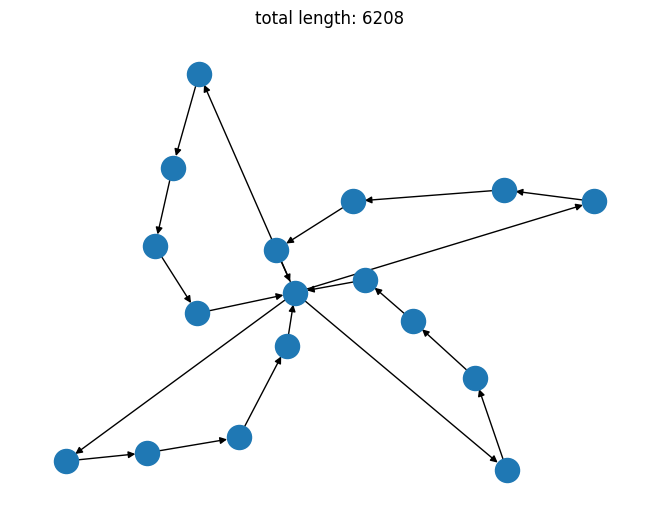

In [20]:
G = nx.DiGraph()

for s in solution:
    for i in range(MAX_STEPS-1):
        start = np.nonzero(s[i])[0][0]
        end = np.nonzero(s[i+1])[0][0]
        if start == 0 and end == 0:
            continue
        else:
            G.add_edge(start, end, weight=d_matrix[start, end])

pos = nx.spring_layout(G, iterations=1000)
nx.draw(G, pos)
plt.title(f'total length: {length}')
plt.show()

# Basic approach

In [6]:
def do_model_all_routes(d_matrix):
    #defining scip task
    model = cp_model.CpModel()

    ###defining variables
    Routes = {}  # x_ijp  - матрица маршрутов

    #___________________________________________________________________________________________________
    # Создание переменных
    for p in range(P):
        for i in range(N):
                for j in range(N):
                    Routes[p, i, j] = model.new_bool_var(name=f'rout{p}_{i}_{j}')

    #___________________________________________________________________________________________________
    # ограничение из матрицы смежности
    for i in range(N):
        for j in range(N):
            for p in range(P):
                if d_matrix[i, j] == 0:
                    model.add(Routes[p, i, j] == 0)
    
    # x_iip =0 - не ездить из города в себя
    for i in range(N):
        for p in range(P):
            model.add(Routes[p, i, i] == 0)

    for p in range(P):
        # обязательно выезжаем из хаба
        model.add(sum(Routes[p, 0, i] for i in range(1, N)) == 1)
        
        # Машина покидает вершину, которую посетила
        for i in range(N):
            model.add(sum(Routes[p, i, j] for j in range(N)) == sum(Routes[p, j, i] for j in range(N)))
        
        # и обязательно возвращаемся в хаб
        model.add(sum(Routes[p, i, 0] for i in range(N)) == 1)
        
        # каждый переход - это переход только в один город
        for j in range(N):
            model.add(sum(Routes[p, j, i] for i in range(N)) <= 1)


    # Проверим что каждый город посетили один раз
    for j in range(1, N):
        model.add(sum(Routes[p, i, j] for p in range(P) for i in range(1, N)) == 1)
    

    # Minimize distance
    objective_func = sum(Routes[p, i, j] * d_matrix[i, j] for i in range(N) for j in range(N) for p in range(P))
    model.minimize(objective_func)
    
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = True
    solver.parameters.max_time_in_seconds = 60.0 * 30
    # callback = Callback(Routes, T_out, Car_Type, day, solver, objective_func)

    # solution_collector = VarArraySolutionCollector(Routes)

    solver.parameters.log_search_progress = True
    solver.parameters.max_time_in_seconds = 60.0 * 20
    # callback = Callback(Routes, T_out, Car_Type, day, solver, objective_func)

    # solver.SearchForAllSolutions(model, solution_collector)
    status = solver.solve(model)
    print(status)
    if status == 3:
        return None

    return np.reshape([solver.value(v) for v in Routes.values()], (P, N , N))

In [7]:
d_matrix = np.array(sample_data['distance_matrix'])

solution = do_model_all_routes(d_matrix)


Starting CP-SAT solver v9.11.4210
Parameters: max_time_in_seconds: 1200 log_search_progress: true
Setting number of workers to 32

Initial optimization model '': (model_fingerprint: 0x6b2da8d5e9140744)
#Variables: 1'156 (#bools: 1'088 in objective)
  - 1'156 Booleans in [0,1]
#kLinear1: 136
#kLinearN: 160 (#terms: 4'556)

Starting presolve at 0.01s
  3.15e-04s  0.00e+00d  [DetectDominanceRelations] 
  3.80e-03s  0.00e+00d  [PresolveToFixPoint] #num_loops=2 #num_dual_strengthening=1 
  3.20e-03s  0.00e+00d  [ExtractEncodingFromLinear] #potential_supersets=92 
[Symmetry] Graph for symmetry has 2'340 nodes and 5'376 arcs.
[Symmetry] Symmetry computation done. time: 0.00136271 dtime: 0.00173976
[Symmetry] #generators: 3, average support size: 544
[Symmetry] 272 orbits with sizes: 4,4,4,4,4,4,4,4,4,4,...
[Symmetry] Num fixable by intersecting at_most_one with orbits: 45 largest_orbit: 4
[Symmetry] Found orbitope of size 272 x 4
  1.35e-04s  0.00e+00d  [DetectDuplicateConstraintsWithDiffere

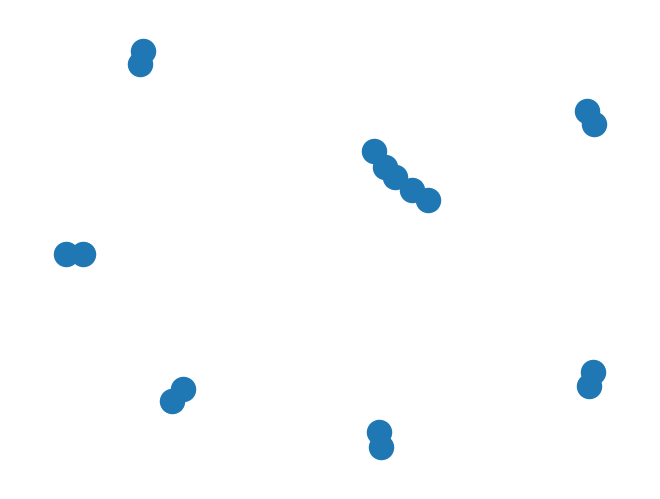

In [8]:
G = nx.from_numpy_array(solution.sum(0), create_using=nx.DiGraph)
pos = nx.spring_layout(G, iterations=100)
nx.draw(G, pos)

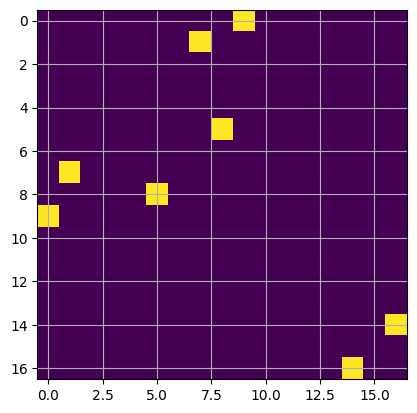

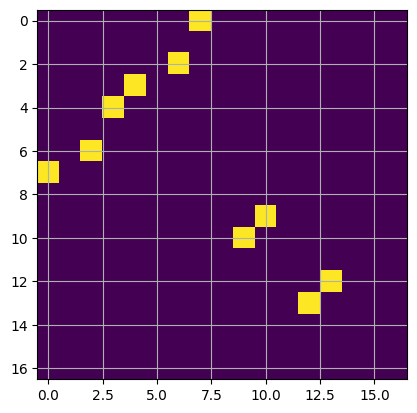

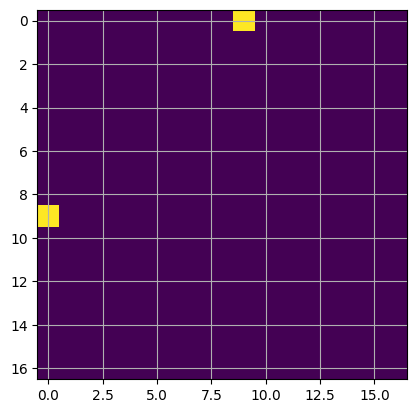

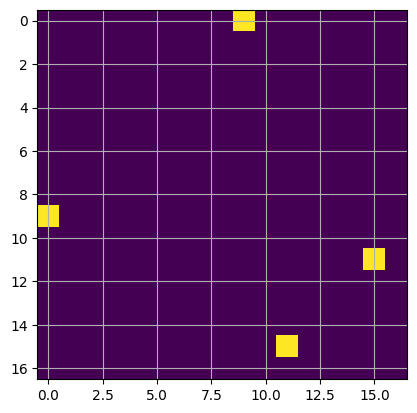

In [9]:
for sol in solution:
    plt.imshow(sol)
    plt.grid()
    plt.show()